Hello... Good morning!
Importing python packages was done.
time = 1396110864600
Zernike functions are defined.
Current Time = 15:45:41
Current Time = 15:45:41

************************************************************
use_gpu = 0, use_hash=1
img shape=  (512, 512)
img shape=  (2000, 2000)

************************************************************
rho theta


2022-01-02:15:45:41, INFO     [AZernike.py:0457] CPU Available RAM: 21.918216192 GB


rho shape = (4000000,)
************************************************************
K = 2, T = 20
img shape=  (4000000,)

Plotting .... 


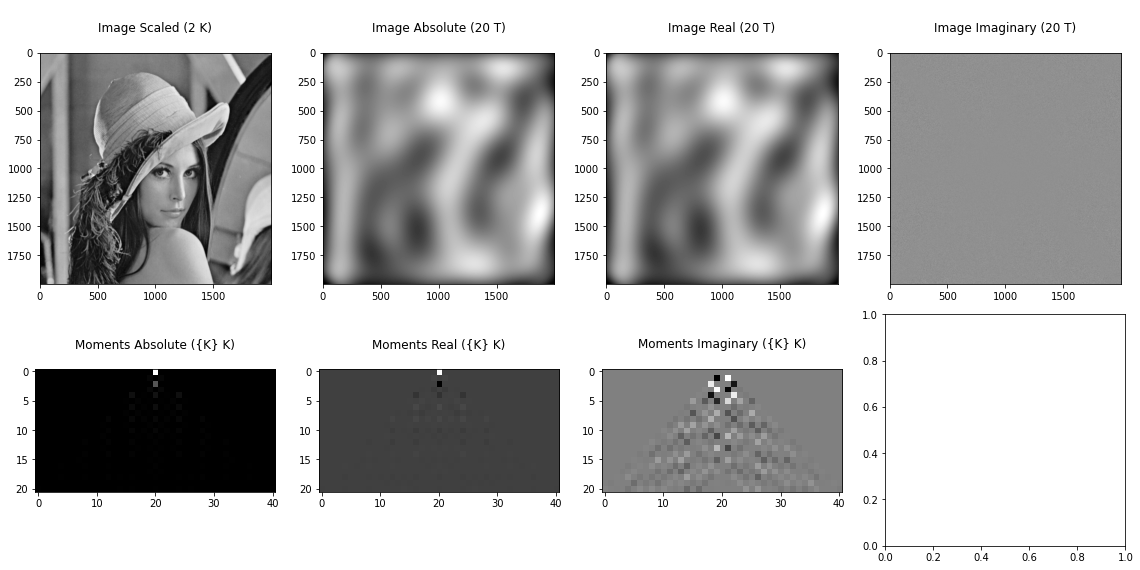


Done.
Wall time: 2min 54s


In [1]:
%%time

from IPython.display import clear_output
clear_output()

# 저니크 모멘트 계산 

from AZernike import *

def pq_list( T ) :
    pqs = []

    for p in range( 0, T + 1 ) : 
        for q in range( -p, p + 1, 2 ) :
            pqs.append( [p, q] )        
        pass
    pass

    return pqs
pass # pq_list

def calc_moments( T, img, rho, theta, dx, dy , **options ) : 
    s = T 
    moments = np.zeros( (s + 1, 2*s + 1), np.complex_ )

    img_flat = img.flatten()

    print( "img shape= ", img_flat.shape )

    pqs = pq_list( T )

    for p, q in pqs :
        v_pq = Vpq( p, q, rho, theta, **options )
        v_pq = np.conjugate( v_pq )
        moment = np.dot( v_pq, img_flat )*dx*dy
        
        moments[ p, s + q ] = moment
        
        #print( f"moment({p:2d}, {q:3d}) = ", moment )
    pass

    if 0 :
        print( "Moments = ", moments )
    pass

    return moments
pass # calc_moments

def restore_image(moments, rho, theta, **options) : 
    np = cupy if options["use_gpu"] else numpy
    
    s = T = moments.shape[0] - 1 
    
    img = np.zeros_like( rho, np.complex_ )
    
    pqs = pq_list( T )
    
    area = 2 # outer type image area in unit_circle
    if "circle_type" in options and "inner" in options["circle_type"] :
        area = pi
    pass        
    
    for p, q in pqs :
        v_pq = Vpq( p, q, rho, theta, ** options )
        img += ((p+1)/area)*moments[p, s + q]*v_pq
    pass 

    s = int( math.sqrt( len( img ) ) )
    
    img = img.reshape( s, s )
    
    return img 
pass ## restore_image

print_curr_time()

line = "*"*60
line2 = "\n" + line

options = {}
options[ "debug" ] = 0 
options[ "use_gpu" ] = 0
options[ "hash" ] = {}
options[ "use_hash" ] = 1  

print( line2 )
print( f"use_gpu = { options['use_gpu'] }, use_hash={ options['use_hash'] }" )

img = cv.imread( 'image/lenna.png', 0 )

print( "img shape= ", img.shape )

img_org = img 

K = 2

np = cupy if options['use_gpu'] else numpy

img = cv.resize( img_org, (int(K*1_000), int(K*1_000)), interpolation=cv.INTER_AREA )

if options['use_gpu']  : 
    img = np.array( img )
pass

print( "img shape= ", img.shape )

print( line2 )
print( "rho theta")

circle_type = "outer"
rho, theta, x, y, dx, dy, k = rho_theta( img, circle_type, **options ) 

print( f"rho shape = {rho.shape}" )

print( line )

T_MAX = 25 

max_mem = max_gpu_memory() if options['use_gpu']  else max_cpu_memory() 

if max_mem < 8 :
    T_MAX = 18
elif max_mem < 25 :
    T_MAX = 20
pass

T = T_MAX
print( f"K = {K}, T = {T}" )

moments = calc_moments(T, img, rho, theta, dx, dy, **options )
img_restored = restore_image(moments, rho, theta, **options )

print( "\nPlotting .... ")

imgs = []

imgs.append( { "title" : f"Image Scaled ({K} K)", "img" : img } )
imgs.append( { "title" : f"Image Absolute ({T} T)", "img" : np.absolute( img_restored ) } )
imgs.append( { "title" : f"Image Real ({T} T)", "img" : img_restored.real } )
imgs.append( { "title" : f"Image Imaginary ({T} T)", "img" : img_restored.imag } )

imgs.append( { "title" : "Moments Absolute ({K} K)", "img" : np.absolute( moments.real ), "colorbar" : 0 } )
imgs.append( { "title" : "Moments Real ({K} K)", "img" : moments.real, "colorbar" : 0 } )
imgs.append( { "title" : "Moments Imaginary ({K} K)", "img" : moments.imag, "colorbar" : 0 } ) 

# 서브 챠트 생성 
col_cnt = 4
row_cnt = len( imgs ) // col_cnt
if col_cnt*row_cnt < len( imgs ) :
    row_cnt += 1
pass

fig, charts = plt.subplots( row_cnt, col_cnt, figsize=(4*col_cnt, 4*row_cnt) )
charts = charts.ravel() if row_cnt*col_cnt > 1 else [charts]
chart_idx = 0 

for img in imgs : 
    t_img = img[ "img" ]
    title = img[ "title" ]
    colorbar = False 
    if "colorbar" in img :
        colorbar = img[ "colorbar" ]

    chart = charts[ chart_idx ] ; chart_idx += 1
    chart.set_title( f"\n{title}\n" )
    pos = chart.imshow( cupy.asnumpy( t_img ) if options["use_gpu"] else t_img, cmap='gray' )
    colorbar and fig.colorbar(pos, ax=chart)
pass

plt.tight_layout(); plt.show()

if "hash" in options : 
    del options[ "hash" ]
pass

del options

print( "\nDone." )